In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from wordcloud import WordCloud
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import models,layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from sklearn.metrics import accuracy_score
%matplotlib inline


In [ ]:
df1 = pd.read_csv('Fake.csv')
df2 = pd.read_csv('True.csv')
df2['target'] = 1
df1['target'] = 0
frames = [df1,df2]
df = pd.concat(frames) #The concat() function in pandas is used to append either columns or rows from one DataFrame to another. 
df['news'] = df['title']+df['text']
df.drop(labels=['title','text'],axis=1,inplace=True)
df.drop(labels=['subject','date'],axis=1,inplace=True) #(1=colums) Return Series with specified index labels removed.When inplace=True is passed, the data is renamed in place (it returns nothing)
df = df.sample(frac = 1) #exampe of the index like 5th news


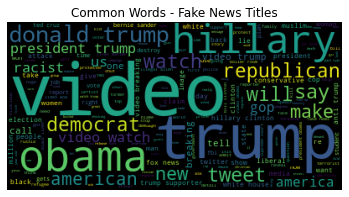

In [ ]:
# Create fake_words variable for input into WordCloud() model
fake_words = ''

# For each headline, lower the text
for headline in df1['title']:
    text = headline.lower() # all letters in healine lowercase
    fake_words = fake_words + text + ' ' # Concatenates every single headline into one string

#Create and generate wordcloud image    
fake_wordcloud = WordCloud().generate(fake_words)

# Display the generated image
plt.title("Common Words - Fake News Titles")
plt.imshow(fake_wordcloud)
plt.axis('off');


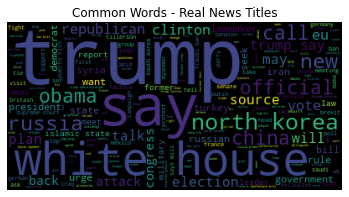

In [ ]:
real_words = ''

# For each headline, lower the text
for headline in df2['title']:
    text = headline.lower() # all letters in healine lowercase
    real_words = real_words + text + ' ' # Concatenates every single headline into one string

#Create and generate wordcloud image    
real_wordcloud = WordCloud().generate(real_words)

# Display the generated image
plt.title("Common Words - Real News Titles")
plt.imshow(real_wordcloud)
plt.axis('off');


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.news, df.target, test_size=0.2, random_state=37) # run it without specifying random_state, you will get a different result, this is expected behavior.

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=37)

In [ ]:
tk = Tokenizer (num_words=1000,
filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n',lower=True, split=" ")
tk.fit_on_texts(X_train)
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)
X_val_seq = tk.texts_to_sequences(X_val)


In [ ]:
print(tk.word_index)

Output hidden; open in https://colab.research.google.com to view.

fit_on_texts Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.

In [ ]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=100)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=100)
X_val_seq_trunc = pad_sequences(X_val_seq, maxlen=100)



pad_sequences is used to ensure that all sequences in a list have the same length

In [ ]:
emb_model = models.Sequential()
emb_model.add(layers.Embedding(len(tk.index_word), 8, input_length=100))
emb_model.add(layers.Flatten()) # It gets the output of the convolutional layers, flattens all its structure to create a single long feature vector to be used by the dense layer for the final classification.
emb_model.add(layers.Dense(1, activation='sigmoid'))


**The** sequential API allows you to create models layer-by-layer for most problems. It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.

Embedding layer enables us to convert each word into a fixed length vector of defined size. The resultant vector is a dense one with having real values instead of just 0’s and 1’s. The fixed length of word vectors helps us to represent words in a better way along with reduced dimensions.

Instead, each input integer is used as the index to access a table that contains all posible vectors. That is the reason why you need to specify the size of the vocabulary as the first argument (so the table can be initialized)

Dense Layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer

In [ ]:
emb_model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.BinaryAccuracy()])
emb_model.fit(x=X_train_seq_trunc,y=y_train,batch_size=256,epochs=5,validation_data=(X_test_seq_trunc,y_test))


Epoch 1/5
106/106 [==============================] - 3s 16ms/step - loss: 0.5955 - binary_accuracy: 0.7669 - val_loss: 0.3823 - val_binary_accuracy: 0.9079
Epoch 2/5
106/106 [==============================] - 2s 14ms/step - loss: 0.2461 - binary_accuracy: 0.9303 - val_loss: 0.1714 - val_binary_accuracy: 0.9467
Epoch 3/5
106/106 [==============================] - 2s 14ms/step - loss: 0.1374 - binary_accuracy: 0.9598 - val_loss: 0.1191 - val_binary_accuracy: 0.9620
Epoch 4/5
106/106 [==============================] - 2s 15ms/step - loss: 0.0991 - binary_accuracy: 0.9708 - val_loss: 0.0941 - val_binary_accuracy: 0.9695
Epoch 5/5
106/106 [==============================] - 2s 15ms/step - loss: 0.0781 - binary_accuracy: 0.9773 - val_loss: 0.0794 - val_binary_accuracy: 0.9743


In [ ]:
prediction = (emb_model.predict(X_test_seq_trunc) > 0.5).astype("int32") #predict the labels of the data values on the basis of the trained model.
accuracy_score(y_test, prediction,  normalize=True)
print(prediction)

[[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]


In [ ]:
#validation 
prediction = (emb_model.predict(X_val_seq_trunc) > 0.5).astype("int32")
accuracy_score(y_val, prediction,  normalize=True)
prediction

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int32)